In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

2024-07-08 07:30:11.226325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 07:30:11.226438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 07:30:11.358642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [3]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/test_set',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    '/kaggle/working/train_set',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


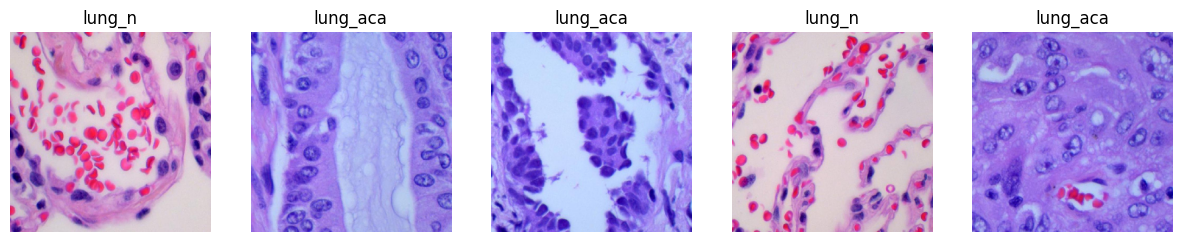

In [10]:
def display_random_images(generator, num_images):
    class_names = list(generator.class_indices.keys())
    
    # Get a batch of images and labels
    images, labels = next(generator)
    
    # Select random indices
    indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[np.argmax(labels[idx])])
        plt.axis('off')
    
    plt.show()

# Display random images from the training set
display_random_images(train_generator, 5)


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create the new model
modelres = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
modelres.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
modelres.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
modelres.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
modelres.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4609 - loss: 1.1062  

I0000 00:00:1720423923.209456     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720423923.261810     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3686 - loss: 1.1028

W0000 00:00:1720423935.954579     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step - accuracy: 0.3688 - loss: 1.1026 - val_accuracy: 0.4429 - val_loss: 1.0644
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.4471 - loss: 1.0606 - val_accuracy: 0.6250 - val_loss: 1.0237
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.5255 - loss: 1.0273 - val_accuracy: 0.5175 - val_loss: 1.0177
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.4931 - loss: 1.0103 - val_accuracy: 0.5558 - val_loss: 0.9823
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.5364 - loss: 0.9887 - val_accuracy: 0.5317 - val_loss: 0.9684
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.5152 - loss: 0.9827 - val_accuracy: 0.6517 - val_loss: 0.9482
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - accuracy: 0.5613 - loss: 0.9574 - val_accuracy: 0.5529 - val_loss: 0.9409
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.5816 - loss: 0.9499 - val_accuracy: 0.525

W0000 00:00:1720424130.496653     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5926 - loss: 1.0882

W0000 00:00:1720424145.090032     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.5939 - loss: 1.0836 - val_accuracy: 0.3333 - val_loss: 4.2128
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.8208 - loss: 0.4281 - val_accuracy: 0.3358 - val_loss: 2.2529
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.8715 - loss: 0.3192 - val_accuracy: 0.4442 - val_loss: 1.9770
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.9039 - loss: 0.2591 - val_accuracy: 0.3529 - val_loss: 2.8817
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.9007 - loss: 0.2378 - val_accuracy: 0.3904 - val_loss: 2.5801
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.8924 - loss: 0.2478 - val_accuracy: 0.7125 - val_loss: 0.7048
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.9285 - loss: 0.2016 - val_accuracy: 0.6913 - val_loss: 0.8261
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.9359 - loss: 0.1484 - val_accuracy: 0.839

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
 1/75 ━━━━━━━━━━━━━━━━━━━━ 45:46 37s/step - accuracy: 0.2188 - loss: 1.1650

W0000 00:00:1720424372.864162     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6316 - loss: 0.9054

W0000 00:00:1720424384.639930     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 301ms/step - accuracy: 0.6335 - loss: 0.9033 - val_accuracy: 0.9221 - val_loss: 0.5116
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9055 - loss: 0.4580 - val_accuracy: 0.9275 - val_loss: 0.3525
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9282 - loss: 0.3333 - val_accuracy: 0.9358 - val_loss: 0.2769
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9456 - loss: 0.2568 - val_accuracy: 0.9379 - val_loss: 0.2358
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9510 - loss: 0.2213 - val_accuracy: 0.9438 - val_loss: 0.2046
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9426 - loss: 0.2002 - val_accuracy: 0.9433 - val_loss: 0.1882
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.9502 - loss: 0.1754 - val_accuracy: 0.9496 - val_loss: 0.1719
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9506 - loss: 0.1674 - val_accuracy: 0.942

W0000 00:00:1720424602.424563     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9450 - loss: 0.1503

W0000 00:00:1720424615.851804     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.9451 - loss: 0.1501 - val_accuracy: 0.9563 - val_loss: 0.1098
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 312ms/step - accuracy: 0.9616 - loss: 0.0896 - val_accuracy: 0.9646 - val_loss: 0.0928
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.9746 - loss: 0.0723 - val_accuracy: 0.9675 - val_loss: 0.0804
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - accuracy: 0.9864 - loss: 0.0477 - val_accuracy: 0.9679 - val_loss: 0.0762
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - accuracy: 0.9857 - loss: 0.0412 - val_accuracy: 0.9688 - val_loss: 0.0726
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - accuracy: 0.9944 - loss: 0.0259 - val_accuracy: 0.9733 - val_loss: 0.0692
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 311ms/step - accuracy: 0.9968 - loss: 0.0237 - val_accuracy: 0.9654 - val_loss: 0.0870
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 312ms/step - accuracy: 0.9935 - loss: 0.0227 - val_accuracy: 0.971

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size

# Define image size and batch size
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/test_set',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    '/kaggle/working/train_set',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Create the new model
modelinc = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
modelinc.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
modelinc.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)

# Unfreeze some layers and fine-tune
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
modelinc.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
modelinc.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
 1/75 ━━━━━━━━━━━━━━━━━━━━ 38:24 31s/step - accuracy: 0.2188 - loss: 1.2491

W0000 00:00:1720424877.085070     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8155 - loss: 0.4562

W0000 00:00:1720424895.261857     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 409ms/step - accuracy: 0.8165 - loss: 0.4539 - val_accuracy: 0.9408 - val_loss: 0.1606
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 318ms/step - accuracy: 0.9443 - loss: 0.1482 - val_accuracy: 0.9175 - val_loss: 0.1833
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.9528 - loss: 0.1239 - val_accuracy: 0.9521 - val_loss: 0.1225
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.9709 - loss: 0.0886 - val_accuracy: 0.9596 - val_loss: 0.1045
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.9771 - loss: 0.0695 - val_accuracy: 0.9592 - val_loss: 0.0977
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 323ms/step - accuracy: 0.9784 - loss: 0.0655 - val_accuracy: 0.9646 - val_loss: 0.0916
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.9781 - loss: 0.0687 - val_accuracy: 0.9704 - val_loss: 0.0896
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.9865 - loss: 0.0515 - val_accuracy: 0.956

W0000 00:00:1720425158.833522     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8701 - loss: 0.3084

W0000 00:00:1720425176.323029     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 395ms/step - accuracy: 0.8708 - loss: 0.3069 - val_accuracy: 0.9604 - val_loss: 0.0965
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.9586 - loss: 0.1057 - val_accuracy: 0.9692 - val_loss: 0.0846
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.9807 - loss: 0.0702 - val_accuracy: 0.9721 - val_loss: 0.0803
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.9938 - loss: 0.0451 - val_accuracy: 0.9700 - val_loss: 0.0786
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.9937 - loss: 0.0338 - val_accuracy: 0.9737 - val_loss: 0.0715
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.9977 - loss: 0.0219 - val_accuracy: 0.9750 - val_loss: 0.0667
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 331ms/step - accuracy: 0.9985 - loss: 0.0170 - val_accuracy: 0.9754 - val_loss: 0.0659
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.9959 - loss: 0.0183 - val_accuracy: 0.976

In [9]:
# Evaluate the ResNet50 model
resnet50_scores = modelres.evaluate(validation_generator)
print("ResNet50 Accuracy: {:.2f}%".format(resnet50_scores[1] * 100))

# Evaluate the VGG16 model
vgg16_scores = model.evaluate(validation_generator)
print("VGG16 Accuracy: {:.2f}%".format(vgg16_scores[1] * 100))

#Evaluate the inceptionv3 model
incv3_scores = modelinc.evaluate(validation_generator)
print("incv3 Accuracy: {:.2f}%".format(incv3_scores[1] * 100))



 1/75 ━━━━━━━━━━━━━━━━━━━━ 19:40 16s/step - accuracy: 0.1250 - loss: 4.7007

W0000 00:00:1720425434.389092     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.3235 - loss: 3.6952
ResNet50 Accuracy: 33.33%


W0000 00:00:1720425512.288872     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 274ms/step - accuracy: 0.9666 - loss: 0.0989
VGG16 Accuracy: 96.33%
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.9845 - loss: 0.0498
incv3 Accuracy: 97.87%
